In [0]:

# Attempting to replicate the results from:
# CheXpert: A large chest radiograph dataset with uncertainty labels and expert comparison
# https://arxiv.org/abs/1901.07031

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# importing necessary files


from fastai.vision import *
from torchvision.models import *
import yaml
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from PIL import Image 
from google.colab.patches import cv2_imshow
import csv

from sklearn.metrics import roc_auc_score

In [0]:
# mounting with google drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# setting path

data_path='/content/drive/My Drive/Colab Notebooks/CXR/'

In [0]:
# taking files as input


ft = pd.read_csv(data_path+'CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv(data_path+'CheXpert-v1.0-small/valid.csv')

In [0]:
ft.size

4244866

In [0]:
ft.shape

(223414, 19)

In [0]:
# First 5000 images for learning

full_train_df=ft[0:5000]

In [0]:
full_train_df.size

95000

In [0]:
full_train_df.shape

(5000, 22)

In [0]:
full_train_df.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [0]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [0]:
print(chexnet_targets)
print(chexpert_targets)

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']


In [0]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

In [0]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [0]:
full_train_df['train_valid'] = False
full_valid_df['train_valid'] = True

In [0]:
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [0]:
full_valid_df.head(2)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64541,study1
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64542,study1


In [0]:
full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

In [0]:
full_train_df.head(2)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2


In [0]:
full_valid_df.head(2)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64541,study1
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64542,study1


In [0]:
full_df = pd.concat([full_train_df, full_valid_df])


In [0]:
print(full_df.shape)
full_df.head(2)


(5234, 22)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2


In [0]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [0]:
full_df.head(10)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1,
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2,Atelectasis;Edema
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,Edema
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,patient00004,study1,
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,patient00004,study1,
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,False,patient00005,study1,
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,False,patient00005,study1,
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,False,patient00005,study2,


In [0]:
# Seed function for randomness 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
def get_sample_df(sample_perc = 0.05):
    
    train_only_df = full_df[~full_df.train_valid]
    valid_only_df = full_df[full_df.train_valid]
    unique_patients = train_only_df.patient.unique()
    mask = np.random.rand(len(unique_patients)) <= sample_perc
    sample_patients = unique_patients[mask]

    sample_df = train_only_df[full_train_df.patient.isin(sample_patients)]
    return pd.concat([sample_df,valid_only_df])

In [0]:
def get_src(df = full_df):
    return (ImageList
        .from_df(df, data_path, 'Path')
        .split_from_df('train_valid')
        .label_from_df('feature_string',label_delim=';')
       )

def get_data(size, src, bs=32):
    return (src.transform(get_transforms(do_flip=False), size=size, padding_mode='zeros')
        .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
def validation_eval(learn):
    acts = full_valid_df.groupby(['patient','study'])[learn.data.classes].max().values

    valid_preds=learn.get_preds(ds_type=DatasetType.Valid)
    preds = valid_preds[0]
    preds_df = full_valid_df.copy()

    for i, c in enumerate(learn.data.classes):
        preds_df[c] = preds[:,i]

    preds = preds_df.groupby(['patient','study'])[learn.data.classes].mean().values

    auc_scores = {learn.data.classes[i]: roc_auc_score(acts[:,i],preds[:,i]) for i in range(len(chexpert_targets))}

    #average results reported in the associated paper
    chexpert_auc_scores = {'Atelectasis':      0.858,
                           'Cardiomegaly':     0.854,
                           'Consolidation':    0.939,
                           'Edema':            0.941,
                           'Pleural Effusion': 0.936}

    max_feat_len = max(map(len, chexpert_targets))

    avg_chexpert_auc = sum(list(chexpert_auc_scores.values()))/len(chexpert_auc_scores.values())
    avg_auc          = sum(list(auc_scores.values()))/len(auc_scores.values())

    [print(f'{k: <{max_feat_len}}\t auc: {auc_scores[k]:.3}\t chexpert auc: {chexpert_auc_scores[k]:.3}\t difference:\
    {(chexpert_auc_scores[k]-auc_scores[k]):.3}') for k in chexpert_targets]

    print(f'\nAverage auc: {avg_auc:.3} \t CheXpert average auc {avg_chexpert_auc:.3}\t Difference {(avg_chexpert_auc-avg_auc):.3}')

def avg_auc_metric(input, targs):
    input=input.detach().cpu()
    targs=targs.detach().cpu().byte()
    auc_scores = [roc_auc_score(targs[:,i],input[:,i]) for i in range(targs.shape[1])]
    auc_scores = torch.tensor(auc_scores)
    return auc_scores.mean()

In [0]:
class SaveCallback(LearnerCallback):
    _order = 99
    def __init__(self, learn):
        super().__init__(learn)
        self.epoch = 0
        self.skip = False
    def on_epoch_end(self, **kwargs):
        self.epoch += 1
        if self.skip: return
        learn.save(f'{datetime.datetime.now():%Y-%m-%d %H:%M} avg AUC:{learn.recorder.metrics[-1][-1].item():.3}')

In [0]:
def get_batch_size(img_size, data_image_size=320, base_batch_size=32):
    pixel_ratio = (img_size/data_image_size)**2
    return 2**math.floor(math.log2(base_batch_size/pixel_ratio))

def get_chexpert_learner(learn=None, img_size=320, size=1, mixup=True, pretrained=True, callback_fns=[]):
    bs = get_batch_size(img_size)

    data = get_data(img_size, get_src(get_sample_df(size)), bs=bs)
    
    if learn:
        learn.data = data
    elif mixup:
        learn = cnn_learner(data, densenet121, callback_fns=callback_fns, pretrained=pretrained, metrics=avg_auc_metric).mixup(stack_y=False)
    else:
        learn = cnn_learner(data, densenet121, callback_fns=callback_fns, pretrained=pretrained, metrics=avg_auc_metric)
    return learn

In [0]:
cbfs = [SaveCallback]
def lr_find_no_cbs(learn):
    learn.callback_fns = [cbf for cbf in learn.callback_fns if cbf not in cbfs]
    lr_find(learn)
    learn.recorder.plot(suggestion=True)
    learn.callback_fns += cbfs

In [0]:
seed_everything(2019)

In [0]:
folder='/content/drive/My Drive/Colab Notebooks/CXR/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'
f1='/content/drive/My Drive/Colab Notebooks/CXR/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg'


In [0]:
img = cv2.imread(folder,  
                  cv2.IMREAD_GRAYSCALE) 

In [0]:

print(img)


[[  1   0  49  49 ...   0   0   0   0]
 [  3   1  50  50 ...   1   1   1   1]
 [  0   0  49  52 ...   1   0   0   0]
 [  1   2  47  48 ...   0   0   0   0]
 ...
 [158 159 173 189 ... 222 231 245 228]
 [157 167 178 168 ... 243 226 229 238]
 [165 172 164 171 ... 249 255 234 240]
 [176 198 163 180 ... 242 245 232 230]]


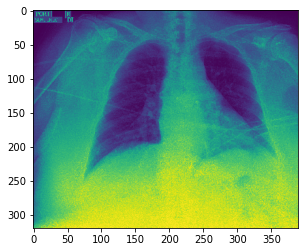

In [0]:
imgplot = plt.imshow(img)

In [0]:
learn = get_chexpert_learner(img_size=64, size=1, callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 1.74E-02


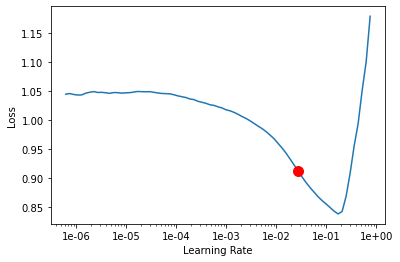

In [0]:
lr_find_no_cbs(learn)

In [0]:
lr = 1e-2
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.965329,0.767057,0.512481,05:56
1,0.835187,0.585861,0.551793,00:54
2,0.711062,0.584117,0.653910,00:54
3,0.640630,0.585379,0.699910,00:52
4,0.597518,0.572144,0.725725,00:53


In [0]:
validation_eval(learn)

Atelectasis     	 auc: 0.661	 chexpert auc: 0.858	 difference:    0.197
Cardiomegaly    	 auc: 0.656	 chexpert auc: 0.854	 difference:    0.198
Consolidation   	 auc: 0.709	 chexpert auc: 0.939	 difference:    0.23
Edema           	 auc: 0.737	 chexpert auc: 0.941	 difference:    0.204
Pleural Effusion	 auc: 0.781	 chexpert auc: 0.936	 difference:    0.155

Average auc: 0.709 	 CheXpert average auc 0.906	 Difference 0.197


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-04


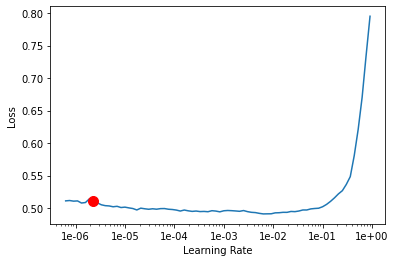

In [0]:
learn = get_chexpert_learner(learn=learn, img_size=128, size=1)
lr_find_no_cbs(learn)

In [0]:
lr = 1e-3
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.491910,0.537291,0.741236,01:16
1,0.484872,0.496621,0.768908,01:15
2,0.477442,0.506936,0.759818,01:15
3,0.470277,0.511847,0.759875,01:15
4,0.464598,0.507250,0.765805,01:17


In [0]:
validation_eval(learn)

Atelectasis     	 auc: 0.718	 chexpert auc: 0.858	 difference:    0.14
Cardiomegaly    	 auc: 0.683	 chexpert auc: 0.854	 difference:    0.171
Consolidation   	 auc: 0.781	 chexpert auc: 0.939	 difference:    0.158
Edema           	 auc: 0.803	 chexpert auc: 0.941	 difference:    0.138
Pleural Effusion	 auc: 0.841	 chexpert auc: 0.936	 difference:    0.0949

Average auc: 0.765 	 CheXpert average auc 0.906	 Difference 0.14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


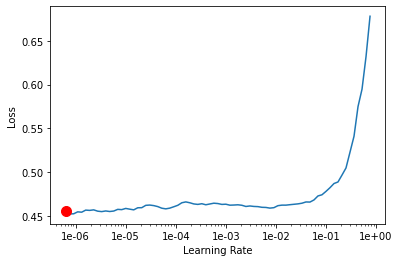

In [0]:
lr_find_no_cbs(learn)

In [0]:
lr = 5e-3
learn.fit_one_cycle(1,slice(lr))

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.473547,0.502906,0.773583,01:18


In [0]:
validation_eval(learn)

Atelectasis     	 auc: 0.764	 chexpert auc: 0.858	 difference:    0.0938
Cardiomegaly    	 auc: 0.662	 chexpert auc: 0.854	 difference:    0.192
Consolidation   	 auc: 0.794	 chexpert auc: 0.939	 difference:    0.145
Edema           	 auc: 0.812	 chexpert auc: 0.941	 difference:    0.129
Pleural Effusion	 auc: 0.841	 chexpert auc: 0.936	 difference:    0.095

Average auc: 0.774 	 CheXpert average auc 0.906	 Difference 0.131
